<a href="https://colab.research.google.com/github/amirhoseinoveis/GradCAM-with-MSTAR/blob/main/GradCAM_with_MSTAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:

import tensorflow as tf
from tensorflow.keras.layers import  Input, Activation, Flatten, Conv2D, MaxPooling2D,  Dense
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import os
from tensorflow.keras import losses, layers

import keras
from tensorflow.keras.applications import MobileNet, EfficientNetB0, ResNet50, VGG16, DenseNet121
from tensorflow.keras.layers import  Input, Activation, Flatten, Conv2D,LeakyReLU, BatchNormalization, MaxPooling2D, Add, Dense, Concatenate, Dropout,  LSTM, TimeDistributed,GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard, Callback, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib


In [58]:

github_url = 'https://raw.githubusercontent.com/amirhoseinoveis/LIME_with_MSTAR/7f0ea0868eec651540c373570060728392070ff5/mstar_3cl_32by32.npz'

# Download the file using wget
path = '/content/mstar_3cl_32by32.npz'
os.system(f'wget {github_url} -O {path}')

# Load the data using np.load
with np.load(path) as data_mstar:
    x_train_mstar = data_mstar['x_train']
    y_train_mstar = data_mstar['y_train']
    x_test_mstar = data_mstar['x_test']
    y_test_mstar = data_mstar['y_test']
x_train_mstar=np.concatenate([x_train_mstar,x_train_mstar,x_train_mstar],axis=-1)
x_test_mstar=np.concatenate([x_test_mstar,x_test_mstar,x_test_mstar],axis=-1)



In [59]:

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.5):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img =( jet_heatmap * alpha + img)
    superimposed_img/=superimposed_img.max()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)

    plt.subplot(1, 3, 2)
    plt.title('Grad-CAM Heatmap')
    plt.imshow(heatmap, cmap='jet')

    plt.subplot(1, 3, 3)
    plt.title('Overlay of Grad-CAM')
    plt.imshow(superimposed_img)


In [60]:
inputs = Input(shape=(32,32,3),name="Input")
x = Conv2D(128, 3, activation="relu", padding='same',name='Conv1')(inputs)
x = MaxPooling2D(2,name='Pool1')(x)
x = Conv2D(32, 3, activation="relu",padding='same',name='Conv3')(x)
x = MaxPooling2D(2,name='Pool2')(x)
x = Conv2D(16, 3, activation="relu",padding='same',name='Conv4')(x)
x = MaxPooling2D(2,name='Pool3')(x)

x = Flatten(name='Vectorize')(x)
outputs= Dense(3,name='FC',activation="softmax")(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['acc'])
model.summary()

Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 32, 32, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 16, 16, 32)          │          36,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 8, 8, 16)            │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool3 (MaxPooling2D)                 │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Vectorize (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC (Dense)                           │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,875 (179.20 KB)

 Trainable params: 45,875 (179.20 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:


hist = model.fit(
x_train_mstar,
to_categorical(y_train_mstar, 3),  # One-hot encode your labels
batch_size=32,
epochs=10,
validation_split=0.15,
shuffle='on',
)


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - acc: 0.4153 - loss: 1.0756 - val_acc: 0.6952 - val_loss: 0.9230
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - acc: 0.6667 - loss: 0.8625 - val_acc: 0.6857 - val_loss: 0.6947
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - acc: 0.7684 - loss: 0.5887 - val_acc: 0.8476 - val_loss: 0.4170
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - acc: 0.8715 - loss: 0.3711 - val_acc: 0.8667 - val_loss: 0.2934
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - acc: 0.9260 - loss: 0.2324 - val_acc: 0.9524 - val_loss: 0.1714
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - acc: 0.9657 - loss: 0.1509 - val_acc: 0.9714 - val_loss: 0.1067
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - acc: 0.9906 - loss: 0.0797 - val_acc: 1.0000 - val_loss: 0.0694
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - acc: 0.9883 - loss: 0.0481 - val_acc: 0.9619 - val_loss: 0.0667
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - ac

In [62]:
classes_in=[0,1,2]
y_hat=model.predict(x_test_mstar)#test the model, prob.


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [63]:
#classification_report
CM=confusion_matrix(y_true=y_test_mstar,y_pred=y_hat.argmax(1))
# Display confusion matrix
print("Confusion Matrix:")
print(CM)
print("classification_report:")

print(classification_report(y_true=y_test_mstar,y_pred=y_hat.argmax(1)))

Confusion Matrix:
[[265   9   0]
 [  3 271   0]
 [  1   2 271]]
classification_report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       274
           1       0.96      0.99      0.97       274
           2       1.00      0.99      0.99       274

    accuracy                           0.98       822
   macro avg       0.98      0.98      0.98       822
weighted avg       0.98      0.98      0.98       822



[0]
[0]
[0]
[1]


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['Input']
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


[1]
[1]
[2]
[2]


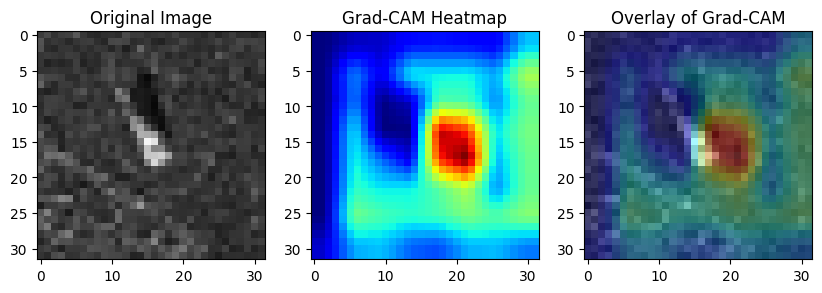

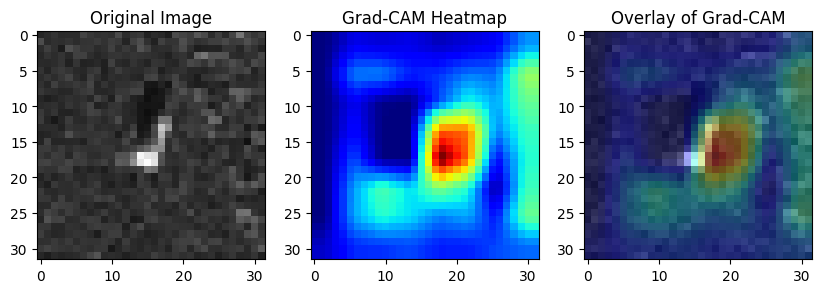

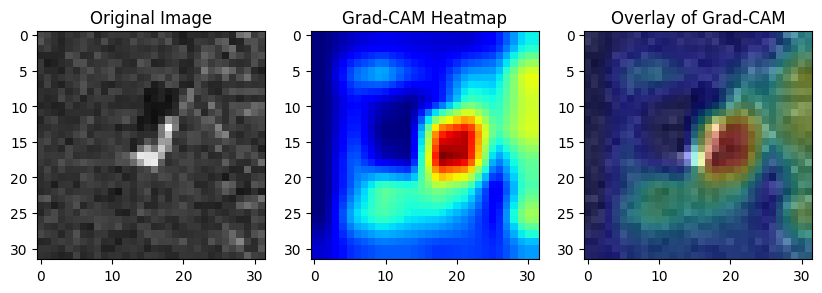

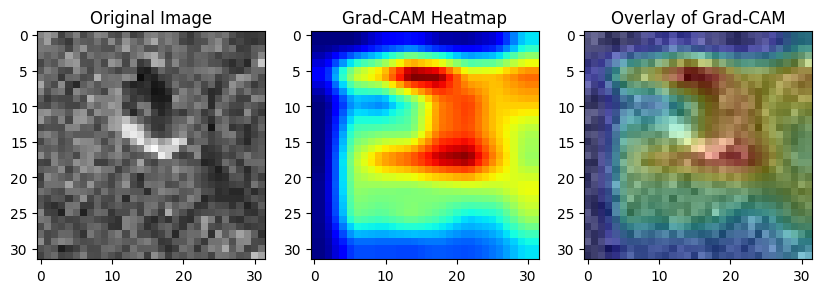

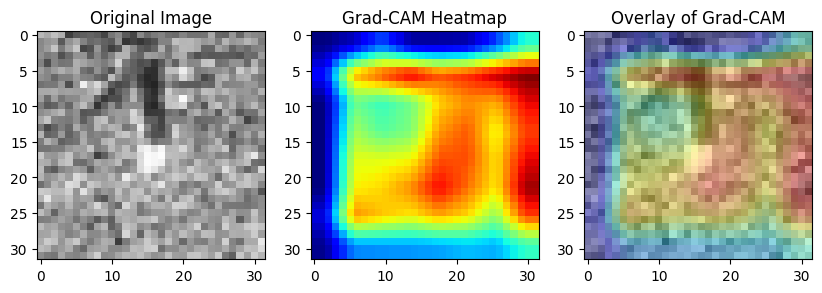

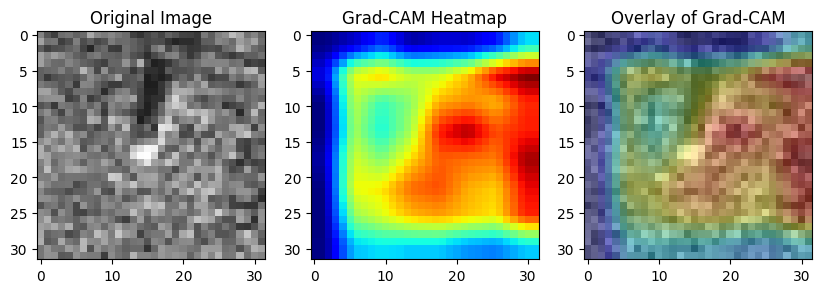

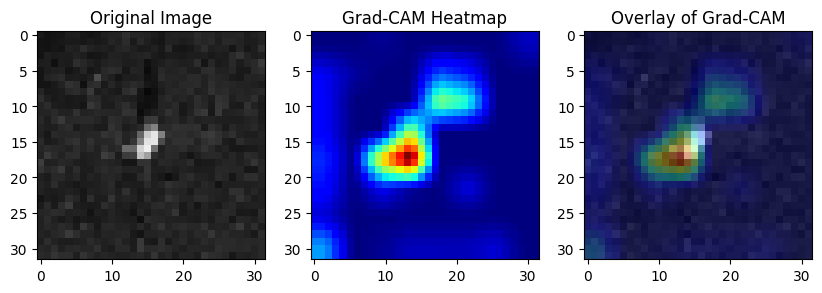

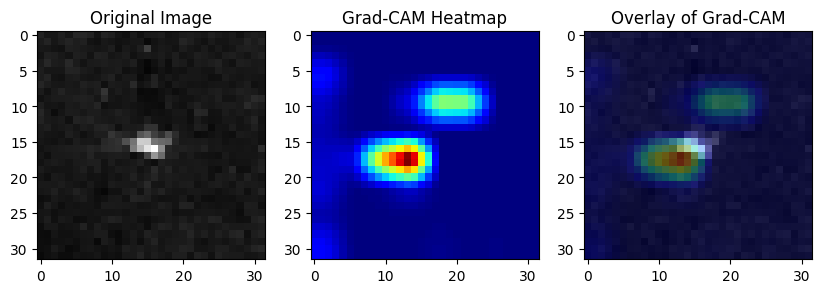

In [64]:
x_test=np.copy(x_test_mstar)
image_size=(32,32)

model.layers[-1].activation = None
for i in range(0,800,100) :

    img_array=x_test[i:i+1]
    print(y_test_mstar[i:i+1])
    #preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name= "Conv4")

    heatmap = tf.image.resize(heatmap[..., tf.newaxis], image_size)
    heatmap = tf.squeeze(heatmap).numpy()



    save_and_display_gradcam(np.squeeze(np.uint8(255 *  img_array)), heatmap)


In [65]:
img_array.min()

0.0196078431372549